In [1]:
## load packages
%matplotlib inline
%load_ext autoreload
import os
import glob
import pyreadr

import pandas as pd
import scanpy as sc
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

sc.set_figure_params(facecolor='white')

import matplotlib.pyplot as plt

from matplotlib import rcParams
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# read multiplex IHC data

In [2]:
adata_path = 'mergedData/mergedData_with_phenotypes_cleaned_filtered.h5ad'

In [3]:
data = pyreadr.read_r("mergedData/mergedData_with_phenotypes_cleaned.rds")[None]
data['Patient'] = data['Patient'].astype(str)
### subset for phenotypes of interest
phenotypesOfInterest = ["CancerCells", "Cytotoxic_T_cells", "M1_macrophages",
                          "M2_macrophages", "Other_immune_cells", "Other_T_cells", 
                          "OtherCells", "unassigned"]
for p in phenotypesOfInterest:
    mask = data['phenotypes'].str.startswith(p)
    data.loc[mask, 'phenotypes'] = data.loc[mask, 'phenotypes'].apply(lambda x: f"{p}_SMPD1" if f"{p}_SMPD1" in x else p)
### label with cells
data.index = "cell_" + data.index.astype(str)
## tidy patine names
data['Patient'] = data['Patient'].str.replace(r'\s*I|\s*II|\s*CTX', '', regex=True)
### subset removing unassigned cells
#data = data[~data['phenotypes'].isin(["OtherCells", "OtherCells_SMPD1", "unassigned"])]
data = data.drop(columns=['CERS1', 'CERS2',"PHH3"], axis= 1)

In [4]:
## metadata
metadata = pd.read_csv("metadata/patients_metadata_clusters.csv", sep = "\t")
metadata['named_clusters'] = metadata['clusters'].apply(lambda x: 'Low' if x == 0 else ('High' if x == 1 else x))
metadata['Patient_ID'] = metadata['Patient_ID'].astype(str)

In [5]:
# Perform an inner join
merged_df = pd.merge(data,metadata, left_on="Patient", right_on="Patient_ID", how='right')

merged_df = merged_df.groupby('.id').filter(lambda x: len(x) >= 100).reset_index(drop=True)

In [6]:
## convert to anndata format
columns = ['AREA', 'COMPACTNESS', 'CD206','CD3', 'CD45', 'CD68', 'CD8',  'CK19', 'SMPD1','EOSIN', 'NUCLEI']
# Drop rows with NaN in specified columns
merged_df = merged_df.dropna(subset=columns).reset_index(drop=True)

obs = merged_df.drop(columns=columns, axis =1)
obs = obs.reset_index().rename(columns={'index': 'Cell_Name'})

X = merged_df[columns]

# Instantiate the scaler object
scaler = MinMaxScaler()
    
# Fit the scaler object to the entire dataframe
scaled_X = scaler.fit_transform(X)

# Convert the scaled array back to a dataframe
scaled_X = pd.DataFrame(scaled_X, columns=X.columns)

In [7]:
## convert to anndata
adata = sc.AnnData(X = X, obs = obs)

In [8]:
adata = adata[~adata.obs['phenotypes'].isin(["OtherCells", "OtherCells_SMPD1", "unassigned"])]

In [9]:
sc.tl.pca(adata)
sc.pp.combat(adata, key='.id')
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [10]:
adata

AnnData object with n_obs × n_vars = 453998 × 11
    obs: 'Cell_Name', '.id', 'Patient', 'Core', 'IMAGENUMBER', 'X', 'Y', 'phenotypes', 'Unnamed: 0', 'Patient_ID', 'Number_of_cores', 'Gender', 'First_diagnosis', 'Stage_at_primary_diagnosis', 'pTu_Local', 'Histo', 'Grading', 'Stage_TNM', 'T', 'N', 'M', 'Vascular_Invasion', 'L', 'Pn', 'OP', 'Resection_margin_R', 'Diabetes_prior_surgery', 'ECOG', 'CA_19_9_base', 'Date_OP', 'Description', 'Start_date_of_Adjuvant_chemo', 'Number_of_cycles', '_Progression_date', 'Age_at_diagnosis', 'Date_of_death_ot_last_followup', 'Progression', 'Progression_free_survival_days', 'Overall_survival_days', 'Death', 'clusters', 'named_clusters'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [11]:
adata.write_h5ad(adata_path,compression='gzip')

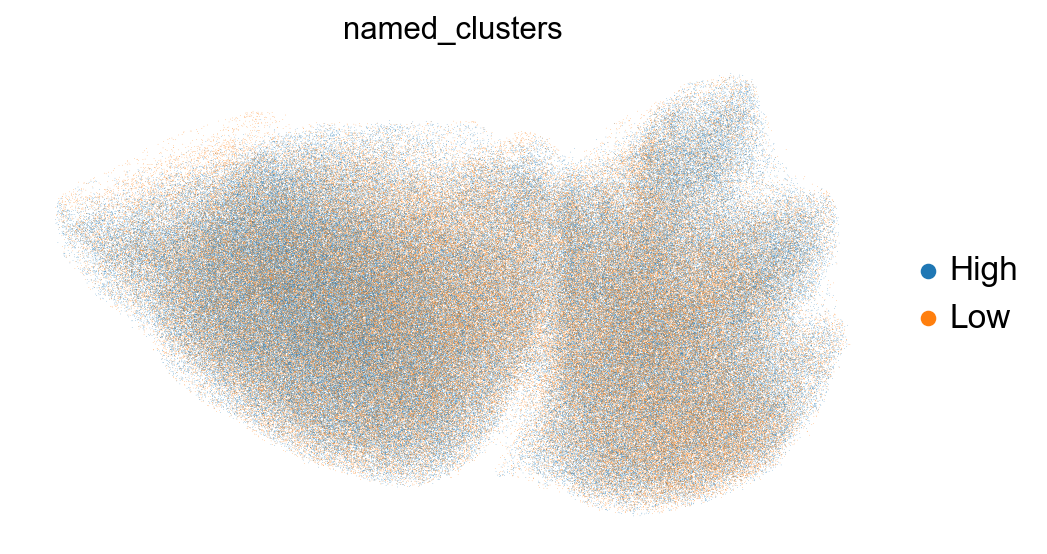

In [12]:
rcParams['figure.figsize'] = 7, 4
sc.pl.umap(adata,
           ncols=2, 
           show=True, 
           color=['named_clusters'], 
           add_outline=False, 
           legend_fontsize=15,
           frameon=False,
           use_raw=False,
           save = "_umap_multiplexIHC_clusters.pdf")

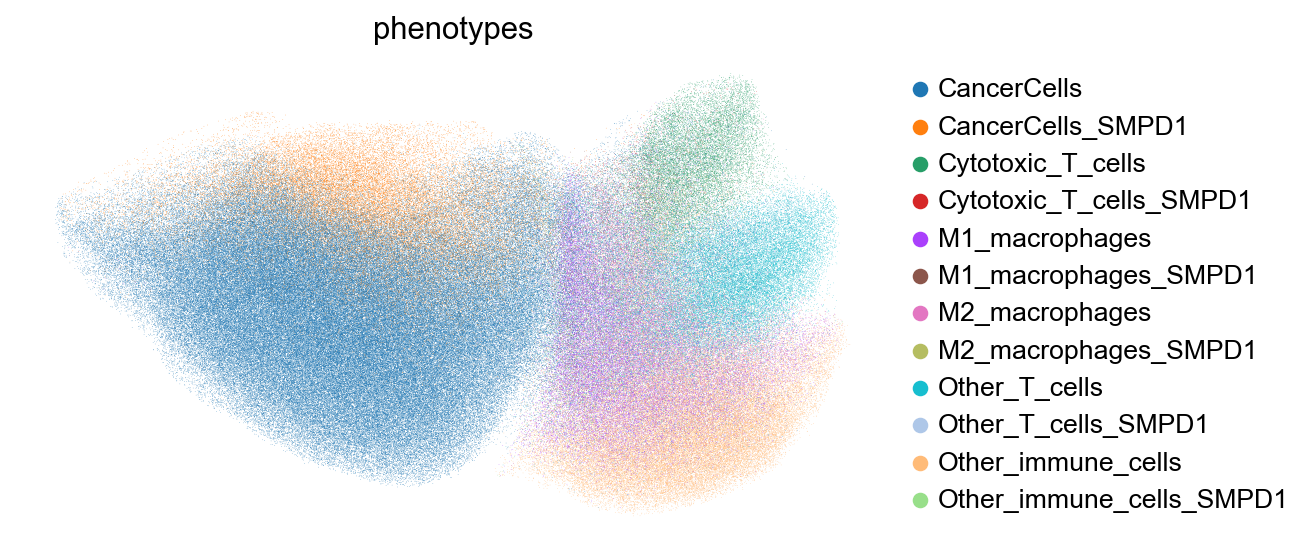

In [13]:
rcParams['figure.figsize'] = 7, 4
sc.pl.umap(adata,
           ncols=1, 
           show=True, 
           color=['phenotypes'], 
           #add_outline=True, 
           legend_fontsize=12,
           frameon=False,
           use_raw=False,
           #outline_color=('grey', 'white'),
           save = "_umap_multiplexIHC_phenotypes.pdf")

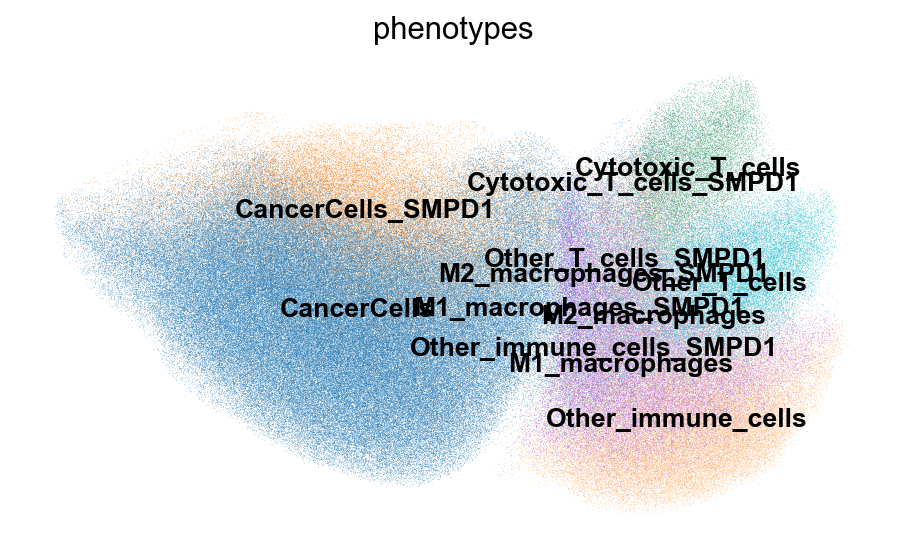

In [14]:
sc.pl.umap(adata,
           ncols=1, 
           show=True, 
           color=['phenotypes'], 
           #add_outline=True, 
           legend_fontsize=12,
           frameon=False,
           use_raw=False,
           legend_loc="on data",
           save = "_umap_multiplexIHC_phenotypes_label.pdf")

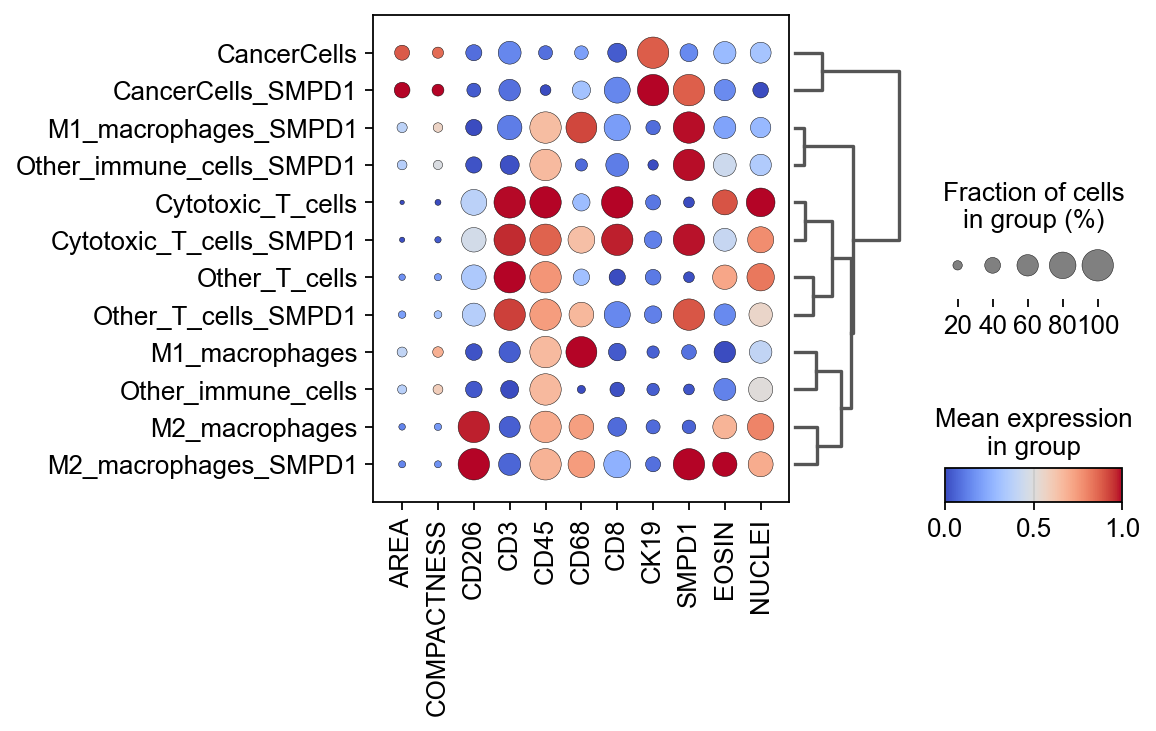

In [15]:
sc.tl.dendrogram(adata, groupby='phenotypes')
sc.pl.dotplot(adata, adata.var_names, groupby='phenotypes', 
              standard_scale='var', dendrogram=True, figsize=[6,4], cmap = "coolwarm", 
              save="_dotplot_multiplexIHC.pdf")